In [1]:
# 📚 Basic Libraries
import pandas as pd
import numpy as np
import warnings
import sys
import os

# 📝 Text Processing
import nltk 
import torch
from datasets import Dataset, DatasetDict
from nltk.stem import WordNetLemmatizer # to lemmatize the words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.feature_extraction.text import CountVectorizer # to create a bag of words
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

# 🤖 Machine Learning
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Add the root directory to sys.path 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Project libraries
import utils.functions as ft
import utils.viz as viz

# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-08 21:41:54.218864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h2 style="color: #1E96FC;">Data Collection</h2>

In [2]:
# Load Training data
data1 = pd.read_csv("../dataset/training_data.csv", header=None, index_col=None, sep='\t')
training_df = data1.copy()
training_df.columns = ['label', 'headline']

In [3]:
training_df.shape

(34152, 2)

In [4]:
# Extract the data
training_df.sample(10)

,label,headline
17004,0,watch hero singlehandedly shut down anti-trump...
21972,1,u.s. attack on syrian base killed five\thoms g...
3777,0,trump‚s selfishness is already killing busines...
16843,0,why are google and facebook attending bilderbe...
3301,0,obama just completely f*cked over trump‚s ‚mus...
7321,0,president obama smoothly dances the tango whil...
565,0,cnn reporter just asked trump the one question...
23234,1,trump to meet with airline ceos on thursday: w...
147,0,sarah huckabee sanders shredded by l.a. times ...
24000,1,bridgewater executive mccormick declines defen...


In [5]:
# Load Testing data
data2 = pd.read_csv("../dataset/testing_data.csv", header=None, index_col=None, sep='\t')
testing_df = data2.copy()
testing_df.columns = ['label', 'headline']

In [6]:
testing_df.shape

(9984, 2)

In [7]:
testing_df.sample(10)

,label,headline
648,2,u.s. says countries should suspend providing w...
802,2,puerto rico power grid faces generational thre...
5388,2,newsmaker: malaysian teacher seen as new 'emir...
9181,2,merkel juncker discuss catalan crisis: eu offi...
4396,2,russia-gate was all the rage across us media ‚...
8585,2,malaysia arrests eight over suspected terror l...
8592,2,venezuela opposition won't attend scheduled ta...
1799,2,boiler room ep #120 ‚ scorched earth media: fr...
2312,2,casting crisis: orlando‚s actors
8670,2,nuclear showdown? navy seal team that killed o...


<h2 style="color: #1E96FC;">Text Processing</h2>

<h3 style="color: #A2D6F9;">Tokenization and Punctuation Removal</h3>

In [8]:
# We will only do text processing to the training data
training_df['tokenized'] = training_df['headline'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha()])
training_df.head()

,label,headline,tokenized
0,0,donald trump sends out embarrassing new year‚s...,"[donald, trump, sends, out, embarrassing, new,..."
1,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus..."
2,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet..."
3,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, name,..."
4,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru..."


<h3 style="color: #A2D6F9;">Lemmatization with POS Helpers</h3>

In [9]:
# Create lmm object
lemm = WordNetLemmatizer()

In [10]:
# using map_pos_tag method to get the pos tag for lemmatization
training_df['lemmatized'] = training_df['tokenized'].apply(lambda x: [lemm.lemmatize(word, ft.map_pos_tag(word)) for word in x])
training_df.head()

,label,headline,tokenized,lemmatized
0,0,donald trump sends out embarrassing new year‚s...,"[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, out, embarrass, new, ev..."
1,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, start, russi..."
2,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet..."
3,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, name,...","[trump, be, so, obsess, he, even, have, name, ..."
4,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, call, out, donald, trump..."


<h3 style="color: #A2D6F9;">Removing Stopwords</h3>

In [11]:
# remove stopwords --> in english
training_df['no_stopwords'] = training_df['lemmatized'].apply(lambda x: list(set(x).difference(stopwords.words('english'))))
training_df.head()

,label,headline,tokenized,lemmatized,no_stopwords
0,0,donald trump sends out embarrassing new year‚s...,"[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, out, embarrass, new, ev...","[disturb, embarrass, eve, message, donald, sen..."
1,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, start, russi...","[investigation, staffer, drunk, bragging, coll..."
2,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, people, joke, clarke, internet, poke..."
3,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, name,...","[trump, be, so, obsess, he, even, have, name, ...","[cod, even, website, image, obsess, name, trump]"
4,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, call, out, donald, trump...","[pope, call, christmas, donald, trump, speech,..."


<h3 style="color: #A2D6F9;">Combining Tokens into Text Blobs</h3>

In [12]:
# Join the words to create a single string
training_df['clean_blob'] = training_df['no_stopwords'].apply(lambda x: " ".join(x))
training_df.head()

,label,headline,tokenized,lemmatized,no_stopwords,clean_blob
0,0,donald trump sends out embarrassing new year‚s...,"[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, out, embarrass, new, ev...","[disturb, embarrass, eve, message, donald, sen...",disturb embarrass eve message donald sends new...
1,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, start, russi...","[investigation, staffer, drunk, bragging, coll...",investigation staffer drunk bragging collusion...
2,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, people, joke, clarke, internet, poke...",sheriff people joke clarke internet poke becom...
3,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, name,...","[trump, be, so, obsess, he, even, have, name, ...","[cod, even, website, image, obsess, name, trump]",cod even website image obsess name trump
4,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, call, out, donald, trump...","[pope, call, christmas, donald, trump, speech,...",pope call christmas donald trump speech francis


In [13]:
ft.save_dataframe_to_csv(training_df, "training_df_cleaned.csv")

The file training_df_cleaned.csv already exists. Skipping save.


<h3 style="color: #A2D6F9;">Bag-of-Words (BoW) Vectorization</h3>

In [14]:
# Take only the most common 1000 words
bow_vect = CountVectorizer(max_features=1000)

In [15]:
# Create the bag of words
X_bag = bow_vect.fit_transform(training_df['clean_blob']).toarray()

In [16]:
# Create the bag of words dataframe
bow_df = pd.DataFrame(X_bag, columns=bow_vect.get_feature_names_out())
bow_df.head()

,abortion,absolutely,abuse,access,account,accuse,accuses,act,action,activist,actor,actually,ad,address,administration,admit,admits,adviser,afghan,afghanistan,africa,african,agency,agenda,agent,agree,ahead,aid,aide,aim,air,al,alabama,alien,allegation,allow,ally,already,ambassador,america,american,amid,anchor,angry,announce,announcement,announces,another,answer,anthem,appeal,appear,approves,april,arabia,arm,army,around,arrest,asia,ask,asks,assault,attack,attempt,attend,attorney,audio,australia,australian,avoid,away,awesome,back,bad,ban,bank,bannon,barack,base,bathroom,battle,become,begin,behind,believe,ben,benghazi,bernie,best,bid,biden,big,bill,billion,billionaire,black,blame,blast,block,blow,board,body,bomb,bombshell,book,boom,boost,border,boy,boycott,break,brexit,briefing,brilliant,bring,britain,british,brutal,brutally,budget,build,bundy,burn,bush,business,bust,cabinet,california,call,camp,campaign,canada,cancel,candidate,capital,car,care,carolina,carson,case,catalan,caucus,caught,cause,ceo,chair,chairman,challenge,chance,change,charge,check,cheer,chicago,chief,child,china,chinese,choice,chris,christian,christie,christmas,church,cia,cite,citizen,city,civil,ck,claim,class,clear,climate,clinton,close,cnn,coal,coalition,college,come,comey,comment,commit,committee,community,company,compare,concern,concerned,conference,confirms,congress,congressional,congressman,conservative,consider,continue,control,convention,conway,cop,corporate,corruption,cost,could,council,counsel,country,court,cover,crazy,create,crime,criminal,crisis,criticism,crooked,crowd,crush,cruz,cuba,cut,cyber,data,daughter,day,dead,deal,death,debate,debt,decision,declares,defeat,defend,defends,defense,delay,dem,demand,democrat,democratic,dems,denies,department,dept,deputy,despite,destroy,destroyed,destroys,detail,detain,die,diplomat,director,disaster,discus,disgust,dispute,dnc,document,doj,dollar,donald,donation,donor,draw,drop,drug,early,east,economic,economy,effort,egypt,elect,election,elizabeth,email,embarrass,embassy,employee,end,endorse,endorsement,endorses,energy,envoy,epa,epic,erdogan,ethic,eu,europe,even,event,ever,every,everyone,evidence,exclusive,executive,expect,expert,explain,explains,expose,eye,face,facebook,fact,factbox,fail,fake,fall,family,fan,far,father,fbi,fear,fed,federal,female,fight,file,final,finally,finance,financial,find,fire,firm,first,five,fix,flag,flashback,flight,flint,florida,flynn,focus,follow,food,force,foreign,former,found,foundation,four,fox,france,fraud,free,french,friday,friend,front,full,fund,funding,furious,future,game,gay,general,george,german,germany,get,girl,give,global,go,good,gop,gov,government,governor,great,green,group,guilty,gun,guy,hack,halt,hammer,hand,handle,hannity,happen,harassment,hard,hariri,harvey,hate,head,health,healthcare,hearing,hell,help,high,highlight,hilarious,hilariously,hillary,hire,history,hit,hold,hollywood,home,homeland,hope,host,house,huge,human,humiliate,humiliates,hurricane,hurt,idea,illegal,illegals,illinois,image,immigrant,immigration,inauguration,include,insane,insult,intel,intelligence,interest,internet,interview,investigate,investigation,invite,iowa,iran,iraq,iraqi,ireland,isi,islamic,israel,israeli,issue,ivanka,jail,james,japan,jeanine,jeff,jerusalem,job,joe,john,johnson,join,joke,journalist,judge,justice,keep,kelly,kellyanne,kerry,key,kick,kid,kill,king,know,korea,korean,kremlin,kushner,labor,lady,last,late,laugh,launch,law,lawmaker,lawsuit,lawyer,lead,leader,leaf,leak,least,leave,lebanon,left,leftist,legal,let,letter,liberal,lie,life,like,likely,limit,line,link,list,literally,little,live,lol,london,look,loom,lose,loses,love,low,macron,maher,major,make,man,manafort,manager,many,march,mark,market,massive,matter,mattis,maxine,may,mayor,mccain,mcconnell,measure,medium,meet,meeting,megyn,melania,meltdown,member,men,merkel,message,mexican,mexico,michael,michelle,michigan,middle,might,migrant,mike,militant,military,million,minister,miss,missile,mnuchin,mock,moment,money,month,moore,moscow,mother,move

In [17]:
bow_df.shape

(34152, 1000)

<h2 style="color: #1E96FC;">EDA</h2>

<Figure size 1000x600 with 0 Axes>

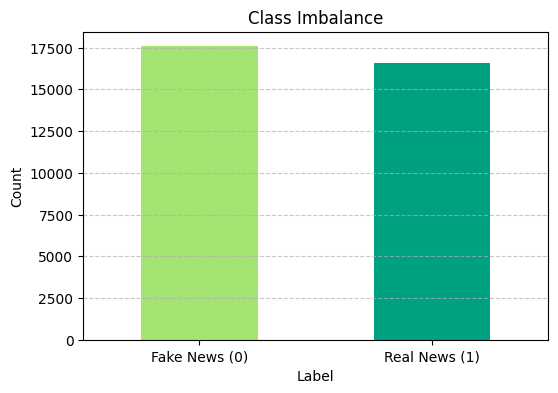

In [18]:
viz.imbalance_plot(training_df,'label')

In [19]:
fake_news = training_df[training_df['label']==0]['clean_blob']
real_news = training_df[training_df['label']==1]['clean_blob']

In [20]:
# Combine all headlines into one string
fake_news_text = " ".join(fake_news)
real_news_text = " ".join(real_news)

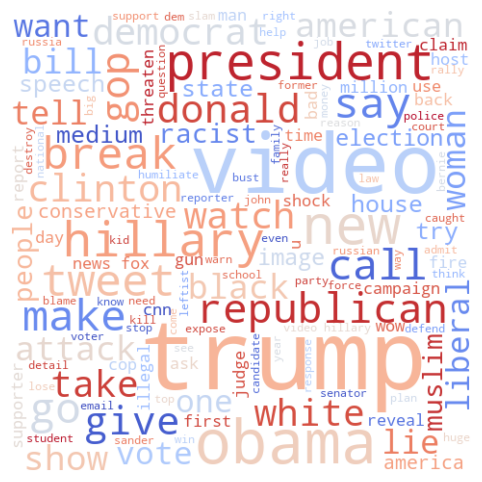

In [21]:
# Word cloud for fake news
viz.wordcloud_plot(fake_news_text, fake_news = True)

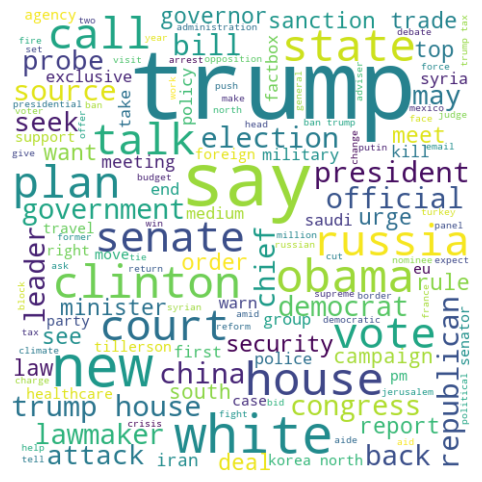

In [22]:
# Word cloud for real news
viz.wordcloud_plot(real_news_text, fake_news = False)

<h3 style="color: #A2D6F9;">Top Words</h3>

In [23]:
bow_df_label = bow_df.copy()
bow_df_label["labels"] = training_df["label"].values

In [25]:
word_counts = bow_df_label.groupby('labels').sum()
word_counts

,abortion,absolutely,abuse,access,account,accuse,accuses,act,action,activist,actor,actually,ad,address,administration,admit,admits,adviser,afghan,afghanistan,africa,african,agency,agenda,agent,agree,ahead,aid,aide,aim,air,al,alabama,alien,allegation,allow,ally,already,ambassador,america,american,amid,anchor,angry,announce,announcement,announces,another,answer,anthem,appeal,appear,approves,april,arabia,arm,army,around,arrest,asia,ask,asks,assault,attack,attempt,attend,attorney,audio,australia,australian,avoid,away,awesome,back,bad,ban,bank,bannon,barack,base,bathroom,battle,become,begin,behind,believe,ben,benghazi,bernie,best,bid,biden,big,bill,billion,billionaire,black,blame,blast,block,blow,board,body,bomb,bombshell,book,boom,boost,border,boy,boycott,break,brexit,briefing,brilliant,bring,britain,british,brutal,brutally,budget,build,bundy,burn,bush,business,bust,cabinet,california,call,camp,campaign,canada,cancel,candidate,capital,car,care,carolina,carson,case,catalan,caucus,caught,cause,ceo,chair,chairman,challenge,chance,change,charge,check,cheer,chicago,chief,child,china,chinese,choice,chris,christian,christie,christmas,church,cia,cite,citizen,city,civil,ck,claim,class,clear,climate,clinton,close,cnn,coal,coalition,college,come,comey,comment,commit,committee,community,company,compare,concern,concerned,conference,confirms,congress,congressional,congressman,conservative,consider,continue,control,convention,conway,cop,corporate,corruption,cost,could,council,counsel,country,court,cover,crazy,create,crime,criminal,crisis,criticism,crooked,crowd,crush,cruz,cuba,cut,cyber,data,daughter,day,dead,deal,death,debate,debt,decision,declares,defeat,defend,defends,defense,delay,dem,demand,democrat,democratic,dems,denies,department,dept,deputy,despite,destroy,destroyed,destroys,detail,detain,die,diplomat,director,disaster,discus,disgust,dispute,dnc,document,doj,dollar,donald,donation,donor,draw,drop,drug,early,east,economic,economy,effort,egypt,elect,election,elizabeth,email,embarrass,embassy,employee,end,endorse,endorsement,endorses,energy,envoy,epa,epic,erdogan,ethic,eu,europe,even,event,ever,every,everyone,evidence,exclusive,executive,expect,expert,explain,explains,expose,eye,face,facebook,fact,factbox,fail,fake,fall,family,fan,far,father,fbi,fear,fed,federal,female,fight,file,final,finally,finance,financial,find,fire,firm,first,five,fix,flag,flashback,flight,flint,florida,flynn,focus,follow,food,force,foreign,former,found,foundation,four,fox,france,fraud,free,french,friday,friend,front,full,fund,funding,furious,future,game,gay,general,george,german,germany,get,girl,give,global,go,good,gop,gov,government,governor,great,green,group,guilty,gun,guy,hack,halt,hammer,hand,handle,hannity,happen,harassment,hard,hariri,harvey,hate,head,health,healthcare,hearing,hell,help,high,highlight,hilarious,hilariously,hillary,hire,history,hit,hold,hollywood,home,homeland,hope,host,house,huge,human,humiliate,humiliates,hurricane,hurt,idea,illegal,illegals,illinois,image,immigrant,immigration,inauguration,include,insane,insult,intel,intelligence,interest,internet,interview,investigate,investigation,invite,iowa,iran,iraq,iraqi,ireland,isi,islamic,israel,israeli,issue,ivanka,jail,james,japan,jeanine,jeff,jerusalem,job,joe,john,johnson,join,joke,journalist,judge,justice,keep,kelly,kellyanne,kerry,key,kick,kid,kill,king,know,korea,korean,kremlin,kushner,labor,lady,last,late,laugh,launch,law,lawmaker,lawsuit,lawyer,lead,leader,leaf,leak,least,leave,lebanon,left,leftist,legal,let,letter,liberal,lie,life,like,likely,limit,line,link,list,literally,little,live,lol,london,look,loom,lose,loses,love,low,macron,maher,major,make,man,manafort,manager,many,march,mark,market,massive,matter,mattis,maxine,may,mayor,mccain,mcconnell,measure,medium,meet,meeting,megyn,melania,meltdown,member,men,merkel,message,mexican,mexico,michael,michelle,michigan,middle,might,migrant,mike,militant,military,million,minister,miss,missile,mnuchin,mock,moment,money,month,moore,moscow,mother,move

In [26]:
top10_fake = word_counts.loc[0].sort_values(ascending=False).head(10)
top10_fake

trump         5605
video         5441
obama         1257
hillary       1131
get            951
break          753
republican     751
president      738
say            719
clinton        699
Name: 0, dtype: int64

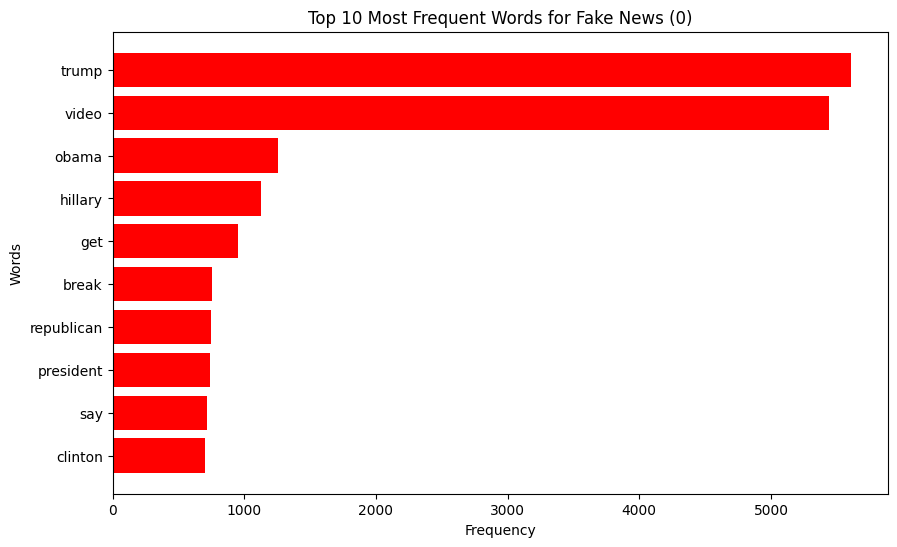

In [27]:
# Plotting
viz.top10_plot(top10_fake, fake = True)

In [28]:
top10_real = word_counts.loc[1].sort_values(ascending=False).head(10)
top10_real

trump         5115
say           2452
house         1376
republican     971
white          778
russia         739
senate         735
bill           683
new            649
clinton        639
Name: 1, dtype: int64

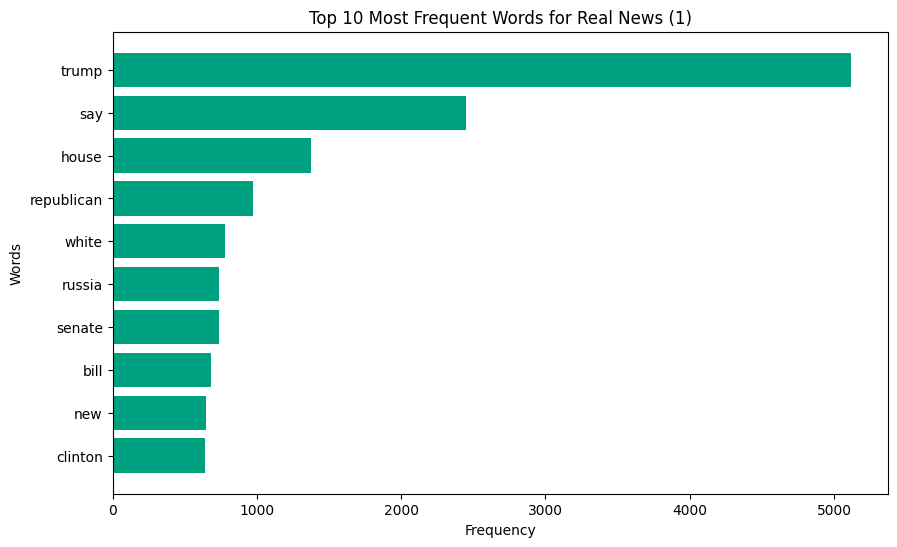

In [29]:
# Plotting
viz.top10_plot(top10_real, fake = False)

<h2 style="color: #1E96FC;">Model Evaluation</h2>

<h3 style="color: #A2D6F9;">Model Training</h3>

In [30]:
# Train-test split
X = bow_df 
y = training_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Try with Naive Bayes, Logistic Regression, and Random Forest
models = {
        'Naive Bayes': BernoulliNB(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    }

In [32]:
metric_classifier = ft.classification_metrics(X_train, X_test, y_train, y_test, models)
metric_classifier

,model,accuracy,precision,recall,f1
0,Naive Bayes,0.902,0.889,0.911,0.900
1,Random Forest,0.894,0.900,0.879,0.889
2,Logistic Regression,0.912,0.901,0.918,0.909


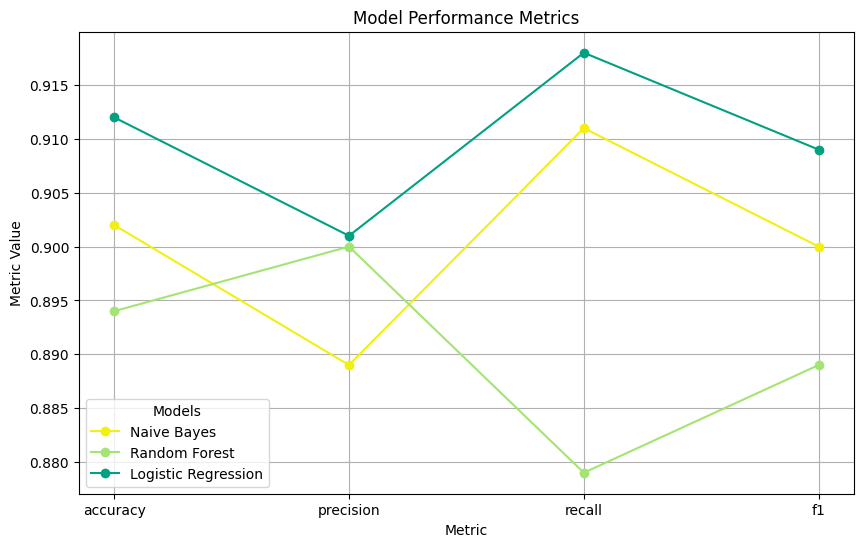

In [33]:
# Plotting the metrics
viz.metrics_plot(metric_classifier)

<h3 style="color: #A2D6F9;">Logistic Regression Comparison: Vectorization</h3>

### Baseline model

In [34]:
# Baseline model with BoW
# Create the bag of words
X_b = bow_vect.fit_transform(training_df['headline']).toarray()
bow_df_b = pd.DataFrame(X_b, columns=bow_vect.get_feature_names_out())

In [35]:
# Baseline model
X_baseline = bow_df_b
y = training_df['label']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_baseline, y, test_size=0.2, random_state=42)

In [37]:
model_baseline = LogisticRegression(max_iter=1000, random_state=42)

In [38]:
# Train and predict the model
model_baseline.fit(X_train_b, y_train_b)
predictions_baseline = model_baseline.predict(X_test_b)
        
# Compute metrics
accuracy_baseline = accuracy_score(y_test_b, predictions_baseline) 
accuracy_baseline

0.9263651002781438

### TF-IDF Vectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

In [40]:
# Fit the model and transform the text data into TF-IDF features
vetorizer_tfidf = vectorizer.fit_transform(training_df['clean_blob']).toarray()
X_tfidf = pd.DataFrame(vetorizer_tfidf, columns=vectorizer.get_feature_names_out())

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [41]:
model_tfidf = LogisticRegression(max_iter=1000, random_state=42)

In [42]:
# Train and predict the model
model_tfidf.fit(X_train_tf, y_train_tf)
predictions_tfidf = model_tfidf.predict(X_test_tf)
        
# Compute metrics
accuracy_tfid = accuracy_score(y_test_tf, predictions_tfidf) 

In [43]:
accuracy_tfid

0.92914653784219

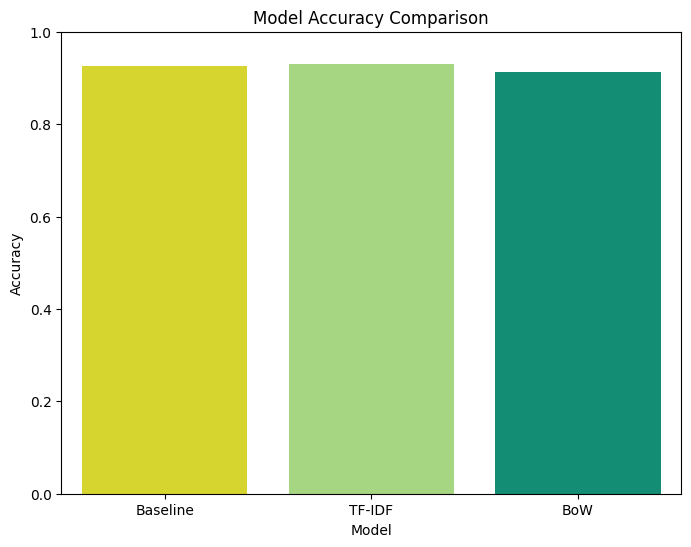

In [44]:
bow_accuracy = 0.912
viz.vector_plot(accuracy_baseline, accuracy_tfid, bow_accuracy)

<h3 style="color: #A2D6F9;">Hypertunning best model: Logistic Regression</h3>

In [51]:
# Define the parameter grid
param_grid = {
    'C': [ 0.1, 1],  # Regularization strength
    'penalty': ['l2'],  # Regularization type (can also try 'l1', 'elasticnet')
    'solver': ['liblinear', 'lbfgs'],  # Solver options
}

In [ ]:
# Using model with TFidf
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model_tfidf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_tf, y_train_tf)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [31]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_tf)

# Print classification report
print(classification_report(y_test_tf, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3529
           1       0.90      0.92      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831



<Figure size 800x600 with 0 Axes>

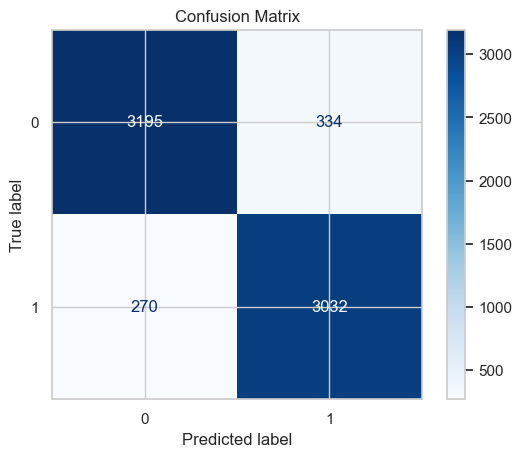

In [32]:
# Confusion matrix
viz.confusion_matrix_plot(y_test_tf, y_pred)

In [ ]:
ft.save_model_to_pickle(best_model, "best_logistic_regression_model.pkl")

<h3 style="color: #A2D6F9;">Make Predictions on Test Data</h3>

In [39]:
# Predicting the labels for test
# Create the bag of words for testing data
X_test = bow_vect.fit_transform(testing_df['headline']).toarray()
y_pred_test = best_model.predict(X_test)  

# Convert predicted numeric labels to 'Fake News' and 'Real News' (if labels are 0 and 1)
testing_df['predicted_label_lr'] = y_pred_test

# Display the first few rows of testing_df to check the new column
testing_df.head()

,label,headline,predicted_label_lr
0,2,copycat muslim terrorist arrested with assault...,1
1,2,wow! chicago protester caught on camera admits...,1
2,2,germany's fdp look to fill schaeuble's big shoes,0
3,2,mi school sends welcome back packet warning ki...,0
4,2,u.n. seeks 'massive' aid boost amid rohingya '...,0


In [ ]:
ft.save_dataframe_to_csv(testing_df, "testing_df_predictions.csv")

<h2 style="color: #1E96FC;">Pre-trained Models: RoBERTa</h2>

In [40]:
# Pass the data as dictionary
train_data = {'text':training_df['clean_blob'], 'label': training_df['label']}
test_data = {'text':testing_df['headline'], 'label': testing_df['label']}

In [ ]:
# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict(train_data),
    'test': Dataset.from_dict(test_data),
})

In [41]:
# Preprocess the data
# Load the pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [42]:
# Functions to preprocess the data
def preprocess_function(examples):
    # Tokenizing the text column; adjust the column name based on your dataset
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=100)

In [44]:
# Apply tokenization to the datasets
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 9984/9984 [00:09<00:00, 1043.65 examples/s]


In [45]:
# Load the pre-trained RoBERTa model for sequence classification
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [52]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

In [53]:
# Define Trainer object
trainer = Trainer(
    model=model_roberta,                        # the model to be trained
    args=training_args,                         # training arguments
    train_dataset=tokenized_dataset['train'],   # training dataset
    eval_dataset=tokenized_dataset['test'],     # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<h3 style="color: #A2D6F9;">Fine-tune RoBERTa</h3>

In [ ]:
# Fine-tune RoBERTa on the training dataset and evaluate it using the testing dataset
trainer.train()

In [ ]:
# Evaluate the model on the test set
results = trainer.evaluate()

<h3 style="color: #A2D6F9;">Predictions</h3>

In [ ]:
predictions = trainer.predict(tokenized_dataset['test'])
# Get predicted class (0 = fake, 1 = real)
preds = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

In [ ]:
# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=["Fake News", "Real News"]))

In [ ]:
viz.confusion_matrix_plot(true_labels, preds)